In [1]:
# Core imports
from mycore import ast2station_rotating, ast2station_rotating2

# Main imports
import heyoka as hy
import pykep as pk
import pygmo as pg
import pygmo_plugins_nonfree as ppnf

# Usual imports
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Jupyter setup
%matplotlib notebook
%load_ext autoreload
%autoreload 2  # Autoreload all modules

ModuleNotFoundError: No module named 'heyoka'

# Setting up the various initial conditions

In [8]:
# Number if nominal trajectories
n_nom_traj = 1000

# List to save [x0, r_target, pop.champion_x]
nom_traj_solutions = []

# Bounds for the sampling
smaL, smaU = 2., 3.
eccL, eccU = 0., 0.25
inclL, inclU = 0., 5. * pk.DEG2RAD

# Sampling
sma_all = np.random.uniform(smaL,smaU,n_nom_traj) * pk.AU
ecc_all = np.random.uniform(eccL,eccU,n_nom_traj)
incl_all = np.random.uniform(inclL,inclU,n_nom_traj)
W_all = np.random.uniform(0,2*np.pi,n_nom_traj)
w_all = np.random.uniform(0,2*np.pi,n_nom_traj)
E_all = np.random.uniform(0,2*np.pi,n_nom_traj)

# Target orbit definition
r_target = 1.3 * pk.AU
omega = np.sqrt(pk.MU_SUN / r_target**3)

<IPython.core.display.Javascript object>


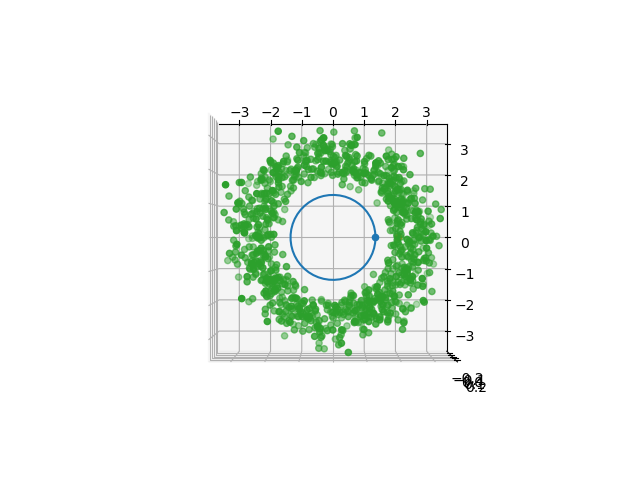

(-3.5, 3.5)

In [17]:
x_pos, y_pos, z_pos = [], [], []
# Visualizing
udp = ast2station_rotating2(
    x0 = [2.*pk.AU,0.,0.,0.,1.,0.],
    r_target = r_target
)
ax = udp.plot_initial_conditions()

for i in range(len(sma_all)):
    r,v = pk.par2ic([sma_all[i], ecc_all[i], incl_all[i], W_all[i], w_all[i], E_all[i]], pk.AU)
    x_pos.append(r[0]/pk.AU)
    y_pos.append(r[1]/pk.AU)
    z_pos.append(r[2]/pk.AU)
ax.scatter(x_pos, y_pos, z_pos)
ax.view_init(90, 270)
ax.set_xlim(-3.5,3.5)
ax.set_ylim(-3.5,3.5)


In [36]:
# Solve nominal case
# Algorithm
uda = ppnf.snopt7(screen_output = False, library = r"C:\Windows\System32\libsnopt7_c.dll", minor_version=2)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-12)
uda.set_numeric_option("Major iterations limit", 200)
algo = pg.algorithm(uda)

nom_traj_solutions = []

In [73]:
def perform_single_run(max_trials = 30, minimum_n_success = 5):
    # Orbital parameters (randomly sampled)
    sma = np.random.uniform(smaL,smaU)*pk.AU
    ecc = np.random.uniform(eccL,eccU)
    incl = np.random.uniform(inclL,inclU)
    W = np.random.uniform(0,2*np.pi)
    w = np.random.uniform(0,2*np.pi)
    E = np.random.uniform(0,2*np.pi)
    osculating = [sma, ecc, incl, W, w, E]

    # Starting state in the inertial frame
    r,v = pk.par2ic(osculating, pk.MU_SUN)
    # Starting state in the rotating frame (in t0 its overlapped)
    v = list(v)
    r = list(r)

    # We move it to the rotating frame
    v[0] = v[0] + omega * r[1]
    v[1] = v[1] - omega * r[0]

    # udp
    x0 = [r[0],r[1],r[2],v[0],v[1],v[2]]
    udp = ast2station_rotating2(
        x0 = x0,
        r_target = r_target
    )
    prob = pg.problem(udp)
    prob.c_tol = 1e-4

    # We solve
    chromosomes_l = []
    for i in range(max_trials):
        pop = pg.population(udp)
        ic_l = np.random.uniform(-1,1,7)
        ic_l[-1] = np.abs(ic_l[-1])
        ic_l = np.append(ic_l, 10 + np.random.rand()*10)
        pop.push_back(x = ic_l)
        pop = algo.evolve(pop)

        err = np.linalg.norm(pop.champion_f[1:])

        if err < 1e-10: 
            print(".", end='')
            chromosomes_l.append(pop.champion_x)
        else:
            print("x", end='')
        if len(chromosomes_l) >= minimum_n_success:
            break
    return x0, r_target, chromosomes_l

In [74]:
db = []
n=0
while True:
    print(n+1," ", end='')
    x0, r_target, chromosomes_l = perform_single_run()
    print()
    if len(chromosomes_l) >= 5:
        db.append([x0, r_target, chromosomes_l])
        n+=1

1  xxxxxxxxxxxxxxxx.xxxxxxxxxxxxx
1  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
1  .x...xxx.
2  xxxx..xxxx..xxxx.
3  x...x..
4  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
4  ...x..
5  .xxx..xx.x.
6  ...x..
7  ...x..
8  xx....x.
9  ..xx..x.
10  x....xxxxx.
11  .xxxxxxxxxxxxxxxxxx.xxxxxx.xx.
11  x....xx.
12  x..x...
13  .x.xx..xxx.
14  ..x..x.
15  x.xx...xxxx.
16  xxxxxxxxx.xxxxxxxxxx.xxxx..xxx
16  xxxxxxxxxx.xxxxxxxxxxxxxxxxxxx
16  ...x..
17  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
17  xxxxxxxxxxxxxxxxxxxxxxxxx..xxx
17  ....x.
18  xxx.xxx....
19  xxxxxxxxxxxxxxxxxx.xxxxxxxxxxx
19  ...x.x.
20  xxxxxxxxxxxxxxxxxxxx..x.xx.xxx
20  x.xxxxx.xxxxxxxx.xxxxxxx.xxx.
21  .....
22  ..x..xxxx.
23  .....
24  .x.x...
25  x.....
26  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
26  ..xxxxxxxxxxx.xx.xxxxxxxxxxxxx
26  .x....
27  .xxxxxxxx.xxx.xxx..
28  xx.....
29  xxxx...xx.x.
30  ....xx.
31  x.....
32  x.x..x.x.
33  .....
34  .....
35  .....
36  ..xx..x.
37  .....
38  ..x..x.
39  .x....
40  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
40  .x....
41  .....
42  ....

651  .x....
652  ..x...
653  ..x.xx.x.
654  xxxxxxxx.xxxxxxxx.xxxxxxxxxxxx
654  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
654  .....
655  .....
656  xxx..xxxxxxx...
657  xxxxxxxxxxx.xxxxxx.xx.xxxxxxxx
657  .xx.xxxx...
658  .....
659  .....
660  x.xxxx.xxxxxxxx.xxxxxxxxx.xxx.
661  .....
662  .....
663  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
663  xxxxxxxxxxxxxx.x.xxxxxxx.xxx.x
663  .xxxxxxxxxxxxxx.xxxx...
664  x....x.
665  x..xx...
666  xx....x.
667  ..x...
668  x.xx.xx.x..
669  xxxxxxxxxxxxxxx.xxxxxxxxxxxxxx
669  x..x...
670  xxx.xxxxxxxxx.xx.x.x.
671  .....
672  .xx.x.xx..
673  .xx.xxx.xxxxxxx.x.
674  xxxxxxxxxxxxxxxx.xxxxxxxxxxxxx
674  x.x....
675  xxxxx.xxxxxxx.xxxxxxx.xxxxx.xx
675  xx..xx...
676  xxxxxxxxxx.xxxxxxxxxxxxxxxxxxx
676  .....
677  xxxxxxxx.xxx.xxxx.xx.xxxxxxxxx
677  x.....
678  .x....
679  ..xx...
680  .xx.x...
681  xxxxxxxxxxxxxxxx.xxxxxxxxxxxxx
681  .xx.x..xxx.
682  ..x...
683  .xx.x...
684  ..xx..x.
685  .xx.x..xx.
686  .....
687  .x....
688  .xx..xxxxxx.x.
689  .x..xx..
690  .....
691 

1277  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
1277  .x...xx.
1278  x.xxxx..xx.x.
1279  x.x.xxxxxxxxxxxx..xxxx.
1280  ..x...
1281  xxxxxxxxx.xxxxxxxxxxxxxxxxxxx.
1281  x.xx.x.xxxxxx.xx.
1282  .xx.x...
1283  x.xx...x.
1284  ...x.x.
1285  xxxxxxxxxxxxx.xx.xxxxxxxxxxxxx
1285  ..xx.xx..
1286  xxxx.xxxx.xxxxxx.xxxxxxxxxxx.x
1286  ..xxxx.xxxxxxxxxx.xx.
1287  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
1287  ..x.xx.x.
1288  x.x..x..
1289  xxxxxxxx.xxxxxxxxxxxxxxxxxxxxx
1289  x..x.xxx.xxx.
1290  x.xxxx..xxxxx.xxxxxxxxx.
1291  xxx.xxx.xxxxxxxxxxxxxxxxxx.xxx
1291  x...x..
1292  .xxxxxxxxxxxxxxxxxxxxx.xxxxxxx
1292  ....x.
1293  .....
1294  ...xx..
1295  ...x..
1296  .....
1297  xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
1297  .xx.xx...
1298  xxxxxxxxx..xxxxx.xxxxxxxxxxxxx
1298  .x....
1299  x.xxxxxxxxxx.x.xxxxxxxx.xxxxxx
1299  x..xx.x.xx.
1300  .xxx..x.x.
1301  ..x.xx..
1302  ..xx..xxxx.
1303  xxxx....xxxx.
1304  xxx.xx..x..
1305  ...x..
1306  xxxxxx.xxxxxxx...xxx.
1307  xx.x.x...
1308  .....
1309  x.xx...xx.
1310  xx.xxxxxxxxxxxx

KeyboardInterrupt: 

In [75]:
#with open("data/nominal_all_value_function_learning.pk", "wb") as file:
#    pkl.dump(db, file)